**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [103]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def print_model_performance(model, X_test, y_test, model_name="Model"):
    """
    Calculates and prints all key metrics for a model in a single line.
    This function includes the crucial zero_division=0 fix.
    """
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics, adding zero_division=0 to prevent errors
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print the results
    print(
        f"{model_name}: "
        f" Accuracy: {accuracy:.4f} "
        f" Precision: {precision:.4f} "
        f" Recall: {recall:.4f} "
        f" F1-Score: {f1:.4f} "
        f" ROC AUC: {roc_auc:.4f}"
    )

# Models and Parameter Grids

In [105]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

k_values_hr = [15, 30, 44] 

# Grid for Decision Tree
param_grid_dt = {
    'feature_selection__k': k_values_hr,
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Grid for k-Nearest Neighbors
param_grid_knn = {
    'feature_selection__k': k_values_hr,
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan']
}

# Grid for Logistic Regression
param_grid_lr = {
    'feature_selection__k': k_values_hr,
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-2, 2, 5),
    'classifier__solver': ['liblinear'],
    'classifier__class_weight': ['balanced']  # <--- THE FIX
}

# Create the list of classifiers to tune
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'k-NN'),
    (LogisticRegression(random_state=42, max_iter=1000), param_grid_lr, 'Logistic Regression')
]


## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [106]:
def load_wine_quality():
    """Load Wine Quality dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
    try:
        data = pd.read_csv(url, sep=';')
    except Exception as e:
        print(f"Error loading Wine Quality dataset: {e}")
        return None, None, None, None, "Wine Quality (Failed)"

    # Create the binary target variable 'good_quality'
    data['good_quality'] = (data['quality'] > 5).astype(int)
    X = data.drop(['quality', 'good_quality'], axis=1)
    y = data['good_quality']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Wine Quality dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold # Make sure to import this

def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']
    X = pd.get_dummies(X, drop_first=True)

    # Note: We are splitting DataFrames here
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    # --- UPDATED BLOCK TO REMOVE CONSTANT FEATURES ---
    selector = VarianceThreshold()
    
    # Fit the selector to learn which columns to remove
    selector.fit(X_train)

    # Get the names of the columns that were NOT removed
    kept_cols = X_train.columns[selector.get_support()]

    # Transform the data (which returns a NumPy array) and immediately
    # convert it back into a DataFrame with the correct column names.
    X_train = pd.DataFrame(selector.transform(X_train), columns=kept_cols)
    X_test = pd.DataFrame(selector.transform(X_test), columns=kept_cols)
    # --- END OF UPDATED BLOCK ---

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [108]:
def load_banknote():
    """Load Banknote Authentication dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

    try:
        data = pd.read_csv(url, header=None)
    except Exception as e:
        print(f"Error loading Banknote dataset: {e}")
        return None, None, None, None, "Banknote (Failed)"

    # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("Banknote Authentication dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [109]:
def load_qsar_biodegradation():
    """Load QSAR Biodegradation dataset"""
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

    try:
        data = pd.read_csv(url, sep=';', header=None)
    except Exception as e:
        print(f"Error loading QSAR dataset: {e}")
        return None, None, None, None, "QSAR (Failed)"

    # Last column is target (RB = ready biodegradable, NRB = not)
    X = data.iloc[:, :-1]
    y = (data.iloc[:, -1] == 'RB').astype(int)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("QSAR Biodegradation dataset loaded successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [110]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import roc_auc_score

# Make sure 'classifiers_to_tune' is defined before this function is called.

def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        adjusted_param_grid = param_grid.copy()
        if 'selectkbest__k' in adjusted_param_grid:
            adjusted_param_grid['selectkbest__k'] = [
                k for k in adjusted_param_grid['selectkbest__k'] if k <= n_features
            ]

        parameter_combinations = list(ParameterGrid(adjusted_param_grid))
        print(f"Testing {len(parameter_combinations)} parameter combinations...")

        for params in parameter_combinations:
            fold_scores = []
            
            for train_idx, val_idx in cv.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                pipeline.set_params(**params)

                pipeline.fit(X_train_fold, y_train_fold)

                y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]

                fold_score = roc_auc_score(y_val_fold, y_pred_proba)
                fold_scores.append(fold_score)

            mean_auc = np.mean(fold_scores)

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params
            
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        final_pipeline.set_params(**best_params)
        final_pipeline.fit(X_train, y_train)
        best_estimators[name] = final_pipeline

    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [111]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        adjusted_param_grid = param_grid.copy()
        if 'selectkbest__k' in adjusted_param_grid:
            adjusted_param_grid['selectkbest__k'] = [
                k for k in adjusted_param_grid['selectkbest__k'] if k <= n_features
            ]

        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            scoring='roc_auc',
            cv=cv_splitter,
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)


        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [112]:
def evaluate_models(X_train, y_train, X_test, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [113]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(
        X_train, y_train, X_test, y_test, manual_estimators, actual_name, "Manual"
    )

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                          for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(
        X_train, y_train, X_test, y_test, builtin_estimators, actual_name, "Built-in"
    )

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 44)
Testing set shape: (441, 44)
------------------------------

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION
--- Manual Grid Search for Decision Tree ---
Testing 54 parameter combinations...
------------------------------------------------------------------------------------------
Best parameters for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'feature_selection__k': 15}
Best cross-validation AUC: 0.7314
--- Manual Grid Search for k-NN ---
Testing 48 parameter combinations...
------------------------------------------------------------------------------------------
Best parameters for k-NN: {'classifier__metric': 'manhattan', 'classif

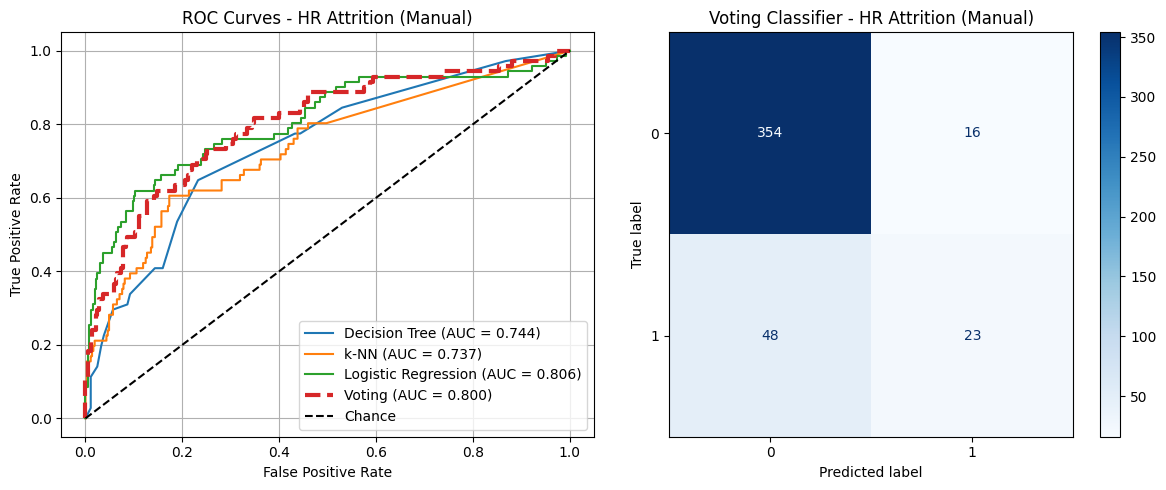


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 10, 'feature_selection__k': 15}
Best CV score: 0.7314

--- GridSearchCV for k-NN ---
Best params for k-NN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 30}
Best CV score: 0.7243

--- GridSearchCV for Logistic Regression ---
Best params for Logistic Regression: {'classifier__C': 0.01, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'feature_selection__k': 44}
Best CV score: 0.8262

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8390
  Precision: 0.5000
  Recall: 0.2958
  F1-Score: 0.3717
  ROC AUC: 0.7436

k-NN:
  Accuracy: 0.8617
  Precision: 0.9167
  Recall: 0.1549
  F1-Score:

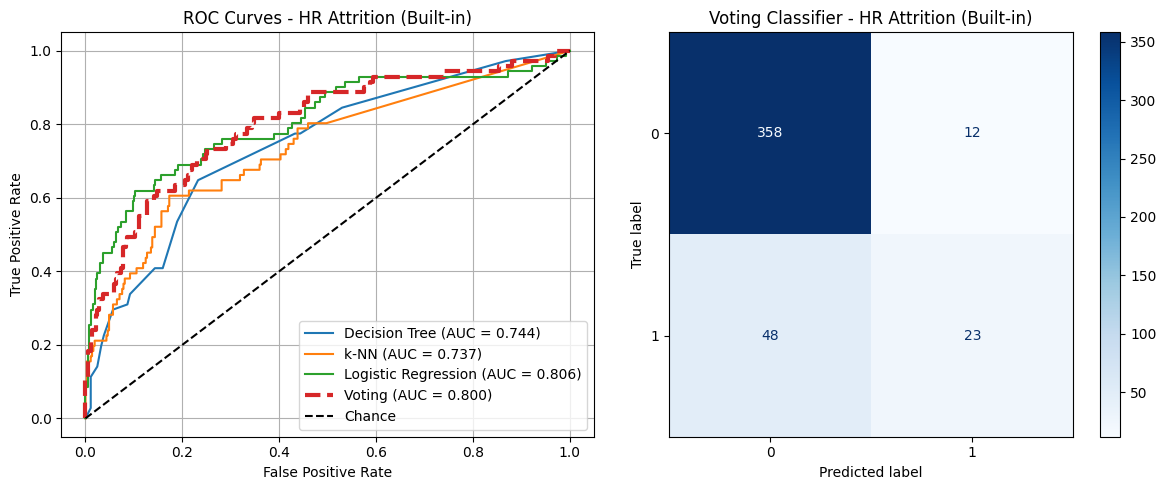


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [114]:
# --- Run Pipeline for All Datasets ---
datasets = [
    (load_hr_attrition, "HR Attrition")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)